In [1]:
import numpy as np

dataset = np.loadtxt('2D_gauss_clusters.txt', skiprows=1, delimiter=',')
dataset

array([[845753., 636607.],
       [812954., 643720.],
       [868217., 609046.],
       ...,
       [706472., 171207.],
       [659128., 142611.],
       [665898.,  98088.]])

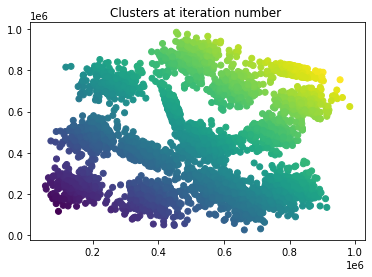

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl


def plot_scatter(X, labels=None, centroids = None, i = ''):
    fig, ax = plt.subplots()
    x = X[:, 0]
    y = X[:, 1]

    if labels:
        scatter = ax.scatter(x, y, c = labels)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(*scatter.legend_elements(), title="Clusters", loc='center left', bbox_to_anchor=(1, 0.5))
        for c in centroids:
            plt.plot(c[0], c[1], marker='*', color='red')
    else:
        ax.scatter(x, y, c = x + y)

    plt.title("Clusters at iteration number " + str(i))
    plt.show()

plot_scatter(dataset)

In [3]:
from numpy.random import uniform

class KMeans:
    def __init__(self, n_clusters, max_iter=100, plot_clusters=False, plot_step=10):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.plot_cluster = plot_clusters
        self.plot_step = plot_step
        self.centroids = None
        self.labels = None

    def fit_predict(self, X):
        """Run the K-means clustering on X.
        :param X: input data points, array, shape = (N,C).
        :return: labels : array, shape = N.
        """
        x0_max = np.max(X[:, 0])
        x1_max = np.max(X[:, 1])

        centroids = []

        for c in range(self.n_clusters):
            centroid = [uniform(x0_max), uniform(x1_max)]
            centroids.append(centroid)

        self.centroids = np.array(centroids)

        for i in range(self.max_iter + 1):
            labels = []
            clusters = [[] for i in range(self.n_clusters)]
            for point in X:
                dist = np.array([np.linalg.norm(point - c) for c in self.centroids])
                label = np.argmin(dist)
                labels.append(label)
                clusters[label].append(point)

            self.labels = np.array(labels)
            clusters = np.array(clusters)

            if self.plot_cluster and i % self.plot_step == 0:
                plot_scatter(X, labels, self.centroids, i)

            equal = True
            #ricalcolo dei centroidi
            for c in range(self.n_clusters):
                updated_centroid = np.mean(clusters[c], axis=0)
                if (updated_centroid != self.centroids[c]).all(): equal = False
                self.centroids[c] = updated_centroid

            if equal: break

        return self.labels

    def dump_to_file(self, filename):
        """Dump the evaluated labels to a CSV file."""
        with open(filename,'w') as fp:
            fp.write('Id,ClusterId\n')
            for i, label in enumerate(self.labels):
                fp.write(f'{i},{label:d}\n')

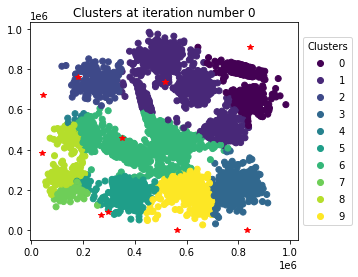

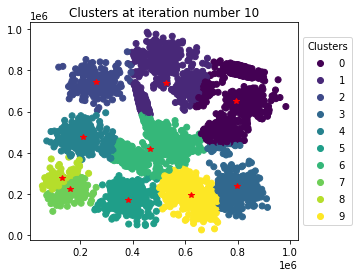

In [4]:
kmeans_gauss = KMeans(10, plot_clusters=True)
labels_gauss = kmeans_gauss.fit_predict(dataset)

In [5]:
chameleon_ds = np.loadtxt("chameleon_clusters.txt", skiprows=1, delimiter=',')
chameleon_ds

array([[ 68.601997, 102.491997],
       [454.665985, 264.80899 ],
       [101.283997, 169.285995],
       ...,
       [267.605011, 141.725006],
       [238.358002, 252.729996],
       [159.242004, 177.431   ]])

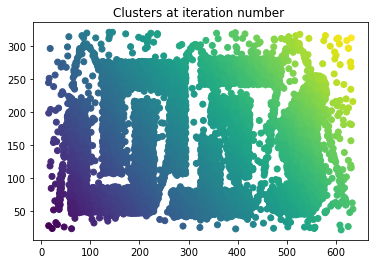

In [6]:
plot_scatter(chameleon_ds)

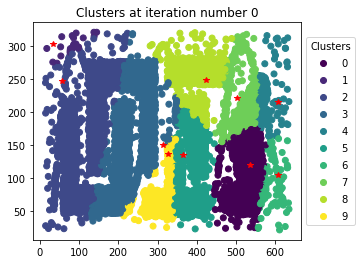

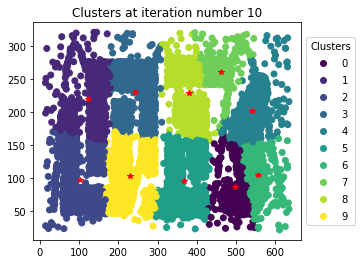

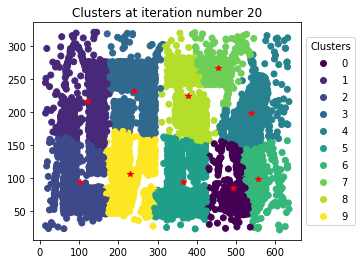

In [7]:
kmeans_cham = KMeans(10, plot_clusters=True)
labels_cham = kmeans_cham.fit_predict(chameleon_ds)

In [8]:
def compute_a(x, x_label, X, labels):
    c_idx = np.where(labels == x_label) # we are including the point itself...
    a = np.mean(np.linalg.norm(x - X[c_idx], axis=1)) # ...because this distance will be 0 when computed from itself.
    return a

def compute_b(x, x_label, X, labels):
    bs = []
    other_labels = np.unique(labels[labels != x_label]) # array with all cluster Ids different from the current one

    for ol in other_labels:
        c_idx = np.where(labels == ol)
        b = np.mean(np.linalg.norm(x - X[c_idx], axis=1))
        bs.append((ol, b))

    neigh, b = min(bs, key=lambda x: x[1])
    return neigh, b

def silhouette_samples(X, labels):
    """Evaluate the silhouette for each point and return them as a list.

    :param X: input data points, array, shape = (N,C).
    :param labels: the list of cluster labels, shape = N. :return: silhouette : array, shape = N
    """
    silhouette = np.zeros(X.shape[0])
    for idx in range(X.shape[0]):
        x = X[idx]
        x_label = labels[idx]

        # compute a
        a = compute_a(x, x_label, X, labels)
        # compute b
        _, b = compute_b(x, x_label, X, labels)

        silhouette[idx] = (b - a) / np.max([a, b])

    return silhouette

def silhouette_score(X, labels):
    """Evaluate the silhouette for each point and return the mean.

    :param X: input data points, array, shape = (N,C).
    :param labels: the list of cluster labels, shape = N. :return: silhouette : float
    """
    return np.mean(silhouette_samples(X, labels))

In [9]:
gauss_score = silhouette_score(dataset, labels_gauss)

cham_score = silhouette_score(chameleon_ds, labels_cham)

gauss_score, cham_score

(0.43929801654214296, 0.37089327031292246)

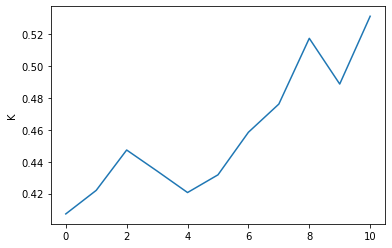

In [10]:
gauss_silhouette = []
for k in range(2, 13):
    kmeans_gauss = KMeans(k)
    gauss_labels = kmeans_gauss.fit_predict(dataset)
    score = silhouette_score(dataset, gauss_labels)
    gauss_silhouette.append(score)


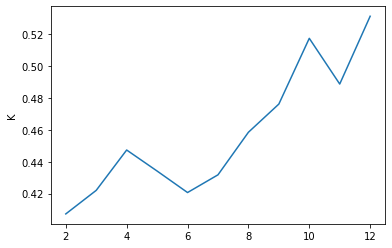

In [11]:
x = np.arange(2,13)
plt.plot(x, gauss_silhouette)
plt.ylabel('K')
plt.show()
